In [ ]:
import pandas as pd

tracks = pd.read_csv('/content/fma-rock-vs-hiphop.csv')

echonest_metrics = pd.read_json('/content/echonest-metrics.json',precise_float=True)

echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']],on='track_id')

print(echo_tracks.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB
None


In [ ]:
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


In [ ]:
features = echo_tracks.drop(['genre_top','track_id'],axis=1)


In [ ]:
labels = echo_tracks['genre_top']
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

Text(0.5, 0, 'Principal Component #')

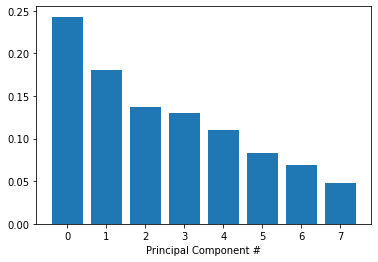

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_ 

fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

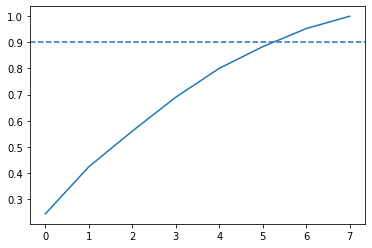

In [ ]:
import numpy as np

cum_exp_variance= np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')

n_components = ((np.where(cum_exp_variance > 0.9))[0][0]) 

pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels,random_state=10)


tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features,train_labels)

pred_labels_tree = tree.predict(test_features)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



In [ ]:
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']
print(hop_only.head())
# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(n=len(hop_only),random_state=10)


# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([hop_only,rock_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels,random_state=10)

     track_id  acousticness  danceability    energy  instrumentalness  \
0           2      0.416675      0.675894  0.634476          0.010628   
1           3      0.374408      0.528643  0.817461          0.001851   
2           5      0.043567      0.745566  0.701470          0.000697   
3         134      0.452217      0.513238  0.560410          0.019443   
118       583      0.748986      0.765886  0.513173          0.957209   

     liveness  speechiness    tempo   valence genre_top  
0    0.177647     0.159310  165.922  0.576661   Hip-Hop  
1    0.105880     0.461818  126.957  0.269240   Hip-Hop  
2    0.373143     0.124595  100.260  0.621661   Hip-Hop  
3    0.096567     0.525519  114.290  0.894072   Hip-Hop  
118  0.614844     0.886914  180.025  0.401672   Hip-Hop  


In [ ]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features,train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels,pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels,pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.76      0.80      0.78       225
        Rock       0.79      0.75      0.77       230

    accuracy                           0.77       455
   macro avg       0.77      0.77      0.77       455
weighted avg       0.77      0.77      0.77       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.80      0.82       225
        Rock       0.81      0.84      0.83       230

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



In [ ]:
from sklearn.model_selection import KFold, cross_val_score
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Set up our K-fold cross-validation
kf = KFold(n_splits=10)
kf.get_n_splits(10)
print(kf)
tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree,pca_projection,labels,cv=kf)
logit_score = cross_val_score(logreg,pca_projection,labels,cv=kf)

KFold(n_splits=10, random_state=None, shuffle=False)


In [ ]:
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7489010989010989 Logistic Regression: 0.782967032967033
